In [2]:
# Load the modules we're going to need
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os
import glob
import librosa
import pandas as pd# Added
from IPython.display import Audio
from sklearn.externals import joblib

In [3]:
# We've previously preprocessed our data and coverted all files to a sample rate of 44100
samplerate = 44100

In [4]:
# Specify where the audio files for training and testing reside
train_folder = './mir_class_train'
test_folder = './mir_class_test'

# Get a list of all the training audio files (must be .WAV files)
train_files = glob.glob(os.path.join(train_folder, '*.wav'))

# Get a list of all the test audio files (must be .WAV files)
test_files = glob.glob(os.path.join(test_folder, '*.wav'))

# Specify the labels (classes) we're going to classify the data into
label0 = 'abscent'
label1 = 'present'
labels = [label0, label1]

In [5]:
# Make 1 second summarization as features with half second of hop length
# 172 frames == 1 second (using 44100 samples per second)
feature_length = 172
half_sec = 86

In [6]:
# Define lists to store the training features and corresponding training labels
train_features = []
train_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists
for tf in train_files:
    
    print("filename: {:s}".format(os.path.basename(tf)))
    
    # Load VGGish audio embeddings
    vggish = pd.read_csv(tf[:-7]+"VGGish.csv",index_col=None, header=None)
    vggish = pd.DataFrame.as_matrix(vggish)
    
    # Read labels for each frame
    f0line = pd.read_csv(tf[:-7]+"MELODY1.csv",index_col=None, header=None)
    f0line = pd.DataFrame.as_matrix(f0line)[:,1]
    
    #print (mfcc.shape)
    #print("number of chunks", int(mfcc.shape[1]/half_sec))
    
    feature_vector = []
    tf_label = []
    
    for idx in range(vggish.shape[0]):
        start = idx*half_sec
        #mfcc_means = np.mean(mfcc[:,start:start+feature_length], 1)
        #mfcc_stddevs = np.std(mfcc[:,start:start+feature_length], 1)
    
        # We could do the same for the delta features like this:
        # mfcc_d1_means = np.mean(np.diff(mfcc), 1)
        # mfcc_d1_stddevs = np.std(np.diff(mfcc), 1)
    
        # Concatenate means and std. dev's into a single feature vector
        feature_vector.append(vggish[idx])
        #print("feature summary: {}".format(len(feature_vector)))
   
        # Adjust labels to our classes
        if len([x for x in f0line[start:start+feature_length] if x > 0]) > half_sec:
            tf_label.append('present')
        else:
            tf_label.append('abscent')
        
    #tf_label = ['present' if x > 0.0 else 'abscent' for x in f0line]

    # Get labels index
    tf_label_ind = [labels.index(lbl) for lbl in tf_label]
    print("file label size: {:d}".format(len(tf_label_ind)))
    
    # Store the feature vector and corresponding label in integer format
    for idx in range(len(feature_vector)-1):
        train_features.append(feature_vector[idx])
        train_labels.append(tf_label_ind[idx]) # Labels are on double rate
    print(" ")

filename: LizNelson_Coldwar_MIX.wav
file label size: 353
 
filename: StrandOfOaks_Spacestation_MIX.wav
file label size: 507
 
filename: AvaLuna_Waterduct_MIX.wav
file label size: 539
 
filename: HezekiahJones_BorrowedHeart_MIX.wav
file label size: 502
 
filename: PurlingHiss_Lolita_MIX.wav
file label size: 532
 
filename: LizNelson_ImComingHome_MIX.wav
file label size: 373
 
filename: TheSoSoGlos_Emergency_MIX.wav
file label size: 346
 
filename: TheScarletBrand_LesFleursDuMal_MIX.wav
file label size: 631
 
filename: PortStWillow_StayEven_MIX.wav
file label size: 248
 
filename: MusicDelta_Rock_MIX.wav
file label size: 26
 
filename: Snowmine_Curfews_MIX.wav
file label size: 572
 
filename: StevenClark_Bounty_MIX.wav
file label size: 602
 
filename: LizNelson_Rainfall_MIX.wav
file label size: 592
 
filename: FacesOnFilm_WaitingForGa_MIX.wav
file label size: 535
 
filename: Wolf_DieBekherte_MIX.wav
file label size: 392
 
filename: SecretMountains_HighHorse_MIX.wav
file label size: 739
 

In [7]:
# Define lists to store the test features and corresponding test labels
test_features = []
test_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists
for tf in test_files:
    
    print("filename: {:s}".format(os.path.basename(tf)))
    
    # Load VGGish audio embeddings
    vggish = pd.read_csv(tf[:-7]+"VGGish.csv",index_col=None, header=None)
    vggish = pd.DataFrame.as_matrix(vggish)
    
    # Read labels for each frame
    f0line = pd.read_csv(tf[:-7]+"MELODY1.csv",index_col=None, header=None)
    f0line = pd.DataFrame.as_matrix(f0line)[:,1]
    
    #print (mfcc.shape)
    #print("number of chunks", int(mfcc.shape[1]/half_sec))
    
    feature_vector = []
    tf_label = []
    
    for idx in range(vggish.shape[0]):
        start = idx*half_sec
        #mfcc_means = np.mean(mfcc[:,start:start+feature_length], 1)
        #mfcc_stddevs = np.std(mfcc[:,start:start+feature_length], 1)
    
        # We could do the same for the delta features like this:
        # mfcc_d1_means = np.mean(np.diff(mfcc), 1)
        # mfcc_d1_stddevs = np.std(np.diff(mfcc), 1)
    
        # Concatenate means and std. dev's into a single feature vector
        feature_vector.append(vggish[idx])
   
        # Adjust labels to our classes
        if len([x for x in f0line[start:start+feature_length] if x > 0]) > half_sec:
            tf_label.append('present')
        else:
            tf_label.append('abscent')
    
    #Get labels index
    tf_label_ind = np.array([labels.index(lbl) for lbl in tf_label])
    print("file label size: {}".format(tf_label_ind.shape))
    
    
    # Store the feature vector and corresponding label in integer format
    for idx in range(len(feature_vector)-1):
        test_features.append(feature_vector[idx])
        test_labels.append(tf_label_ind[idx])
    print(" ")

filename: HeladoNegro_MitadDelMundo_MIX.wav
file label size: (377,)
 
filename: SweetLights_YouLetMeDown_MIX.wav
file label size: (815,)
 
filename: TheDistricts_Vermont_MIX.wav
file label size: (474,)
 
filename: MusicDelta_Rockabilly_MIX.wav
file label size: (53,)
 
filename: Schubert_Erstarrung_MIX.wav
file label size: (361,)
 


In [8]:
# Create a scale object
scaler = sklearn.preprocessing.StandardScaler()

# Learn the parameters from the training data only
scaler.fit(train_features)

# Apply the learned parameters to the training and test sets:
train_features_scaled = scaler.transform(train_features)

In [9]:
test_features_scaled = scaler.transform(test_features)

# Note, the first 2 operations (learning the standardization parameters from the training data 
# and applying them to the the training data) can be performed in one line using:
# train_features_scaled = scaler.fit_transform(train_features)

In [10]:
# save the scaler to disk
filename = 'scaler_VGGish.sav'
joblib.dump(scaler, filename)

['scaler_VGGish.sav']

<h2> Step 3: model training</h2>

Now that all of our features are computed, we can train a clasification model! In this example we're going to use the following model: the support vector machine classifier. 

In [14]:
# Use scikit-learn to train a model with the training features we've extracted

# Lets use a SVC with default parameters: kernel RBF 
clf = sklearn.svm.SVC()

# Fit (=train) the model
clf.fit(train_features_scaled, train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [12]:
# save the model to disk
filename = 'finalized_model_VGGish.sav'
joblib.dump(clf, filename)

['finalized_model_VGGish.sav']

In [15]:
# Now lets predict the labels of the test data!
predictions = clf.predict(test_features_scaled)

In [16]:
# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
print(accuracy)

0.5913253012048193


In [17]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
print(cm)

[[732 432]
 [416 495]]


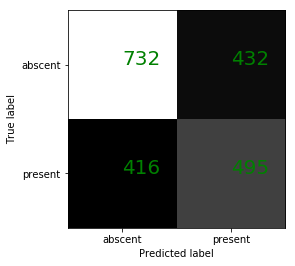

In [18]:
fig, ax = plt.subplots()
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=20, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels)
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()

### Random Forest Classifier with scaler

In [19]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(n_estimators=500)

# Fit (=train) the model
clf2.fit(train_features_scaled, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<h2>Step 4: model evaluation Random Forest Classifier (testing)</h2>

In [20]:
# Now lets predict the labels of the test data!
predictions = clf2.predict(test_features_scaled)

<h3>Model accuracy</h3>

In [21]:
# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
print(accuracy)

0.6028915662650602


<h3>Confusion matrix</h3>

In [22]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
print(cm)

[[761 403]
 [421 490]]


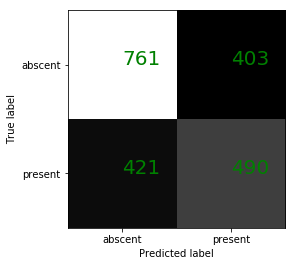

In [23]:
fig, ax = plt.subplots()
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=20, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels)
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()

### Random Forest Classifier without scaler

In [24]:
from sklearn.ensemble import RandomForestClassifier
clf3 = RandomForestClassifier(n_estimators=500)

# Fit (=train) the model
clf3.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<h2>Step 4: model evaluation Random Forest Classifier (testing)</h2>

In [25]:
# Now lets predict the labels of the test data!
predictions = clf3.predict(test_features)

<h3>Model accuracy</h3>

In [26]:
# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
print(accuracy)

0.6014457831325302


<h3>Confusion matrix</h3>

In [27]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
print(cm)

[[760 404]
 [423 488]]


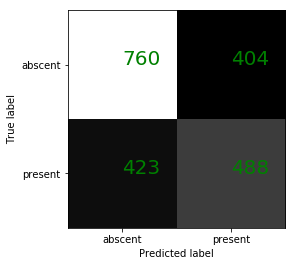

In [28]:
fig, ax = plt.subplots()
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=20, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels)
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()